<a href="https://colab.research.google.com/github/nmarizani/ml_techniques1_summative/blob/main/Mental_Health_Support_conversations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Healthcare Chatbot - Data Preprocessing
# Dataset: Mental Health Conversations at Dataset.csv

# Dataset inspection

In [ ]:
# Imports & Dataset Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
from transformers import AutoTokenizer
from datasets import load_from_disk
from tqdm import tqdm
import tensorflow as tf
import time

In [ ]:
# Load dataset
df = pd.read_csv('dataset.csv')

In [ ]:
# Dataset info
print("Dataset Loaded Successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Dataset Loaded Successfully!
Shape: (3507, 3)

Columns: ['Context', 'Response', 'LLM']

Missing Values:
 Context     0
Response    0
LLM         0
dtype: int64

Duplicate Rows: 0


In [ ]:
# First 5 rows
df.head()

,Context,Response,LLM
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",I understand that you're feeling incredibly l...
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",I'm sorry to hear that you've been feeling wo...
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,I'm glad you've reached out to me today. I un...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,I'm sorry to hear that you're feeling this wa...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,I'm glad you've reached out to me to talk abo...


In [ ]:
print(df.columns)

Index(['Context', 'Response', 'LLM'], dtype='object')


# Exploratory Data Analysis

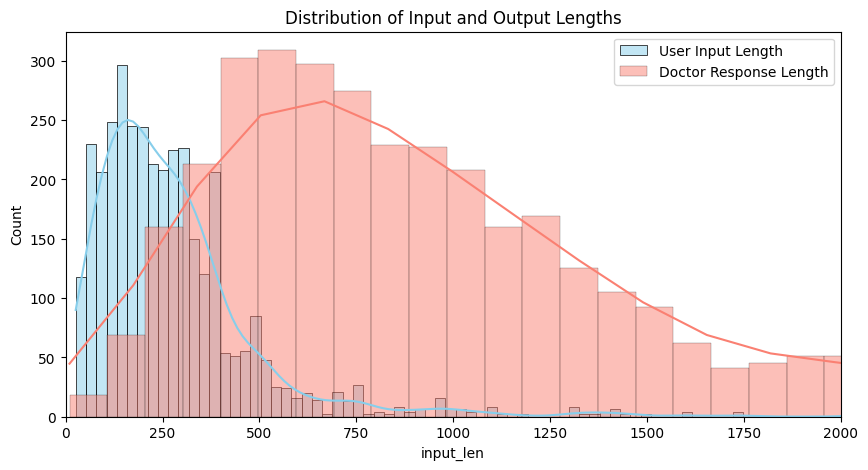

In [ ]:
# Check distribution of text lengths
df["input_len"] = df["Context"].astype(str).apply(len)
df["output_len"] = df["Response"].astype(str).apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df["input_len"], color="skyblue", label="User Input Length", kde=True)
sns.histplot(df["output_len"], color="salmon", label="Doctor Response Length", kde=True)
plt.legend()
plt.title("Distribution of Input and Output Lengths")
plt.xlim(0,2000)
plt.show()

# EDA Insights:

- Inputs average around 25–1250 characters, responses are longer (0–1750).
- Each entry has a emotional question, and the professional’s reply.
- No missing or duplicate rows, data quality is high.
- Domain specificity: 100% mental healthcare-related queries and expert answers.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-3905921533.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Frequency', y='Word', data=context_words_df, palette='viridis')
/tmp/ipython-input-3905921533.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Frequency', y='Word', data=response_words_df, palette='magma')


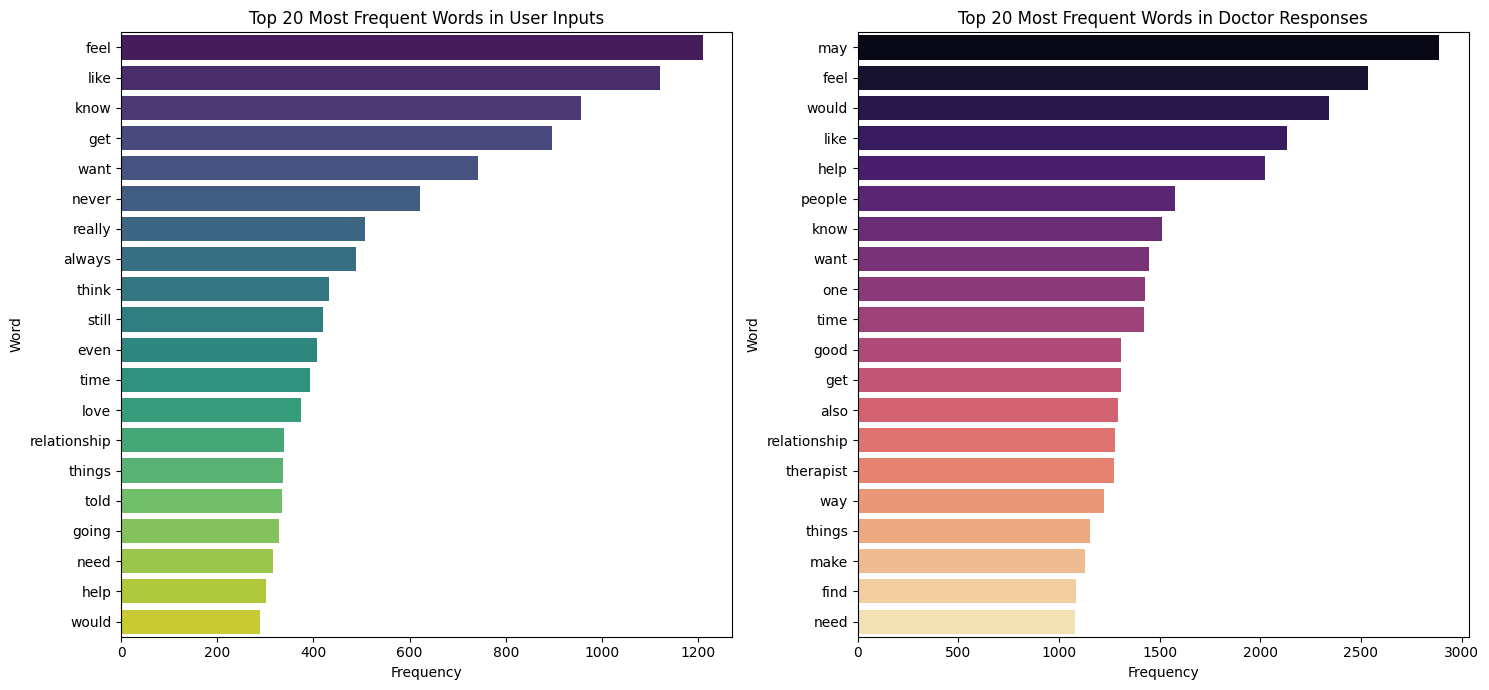

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_n_words(corpus, n=None):
    words = []
    for text in corpus:
        for word in text.split():
            if word.lower() not in stop_words and word.isalpha(): # Exclude stop words and non-alphabetic words
                words.append(word.lower())
    return Counter(words).most_common(n)

# Get top words for Context and Response
top_context_words = get_top_n_words(df['Context'], 20)
top_response_words = get_top_n_words(df['Response'], 20)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

context_words_df = pd.DataFrame(top_context_words, columns=['Word', 'Frequency'])
sns.barplot(ax=axes[0], x='Frequency', y='Word', data=context_words_df, palette='viridis')
axes[0].set_title('Top 20 Most Frequent Words in User Inputs')

response_words_df = pd.DataFrame(top_response_words, columns=['Word', 'Frequency'])
sns.barplot(ax=axes[1], x='Frequency', y='Word', data=response_words_df, palette='magma')
axes[1].set_title('Top 20 Most Frequent Words in Doctor Responses')

plt.tight_layout()
plt.show()

# Visualizing the mental health vocabulary
The above graphs show us some of the frequently used words in mental health conversations

In [ ]:
# Show some random sample pairs
for i in range(3):
    # Check if 'Context', 'Response', and 'LLM' columns exist before accessing
    if 'Context' in df.columns and 'Response' in df.columns and 'LLM' in df.columns:
        print(f"\nPatient: {df['Context'][i]}")
        print(f"Doctor (Response): {df['Response'][i][:300]}...\n")
        print(f"Doctor (LLM): {df['LLM'][i][:300]}...\n")
    else:
        print("Required columns ('Context', 'Response', or 'LLM') not found in the DataFrame.")
        break # Exit the loop if columns are missing

# Check for unique 'Context' entries as 'instruction' is not available
if 'Context' in df.columns:
    print("\nUnique Context entries:", df['Context'].nunique())
else:
    print("\n'Context' column not found in the DataFrame.")


Patient: I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?
Doctor (Response): If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and...

Doctor (LLM):  I understand that you're feeling incredibly low right now, and it's not uncommon to have thoughts about your worthiness or value as a person. These feelings can be very intense and difficult to cope with.

Firstly, I want to reassure you that your feelings are valid, but they are not an accurate re...


Patient: I'm goin

# Text cleaning and Normalization

In [ ]:
# Cleaning
def clean_text(text):
    if not isinstance(text, str):
        text = str(text or "")
    text = re.sub(r"http\S+|www\S+", "", text)           # remove URLs
    text = re.sub(r"<.*?>", "", text)                    # remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\s]", "", text)  # remove emojis/symbols
    text = re.sub(r"\s+", " ", text).strip()             # normalize whitespace
    return text

In [ ]:
# Normalisation
def normalize_text(text):
  text = text.lower()
  text = re.sub(r"\bbp\b", "blood pressure", text)
  text = re.sub(r"\bhr\b", "heart rate", text)
  text = re.sub(r"\btemp\b", "temperature", text)
  return text

In [ ]:
# Apply cleaning
for col in ["Context", "Response"]:
    df[col] = df[col].astype(str).map(clean_text).map(normalize_text)

# Combine prompt + response
# Assuming 'Context' is the patient's input and 'Response' is the doctor's response
df["prompt"] = "Patient: " + df["Context"]
df["response"] = df["Response"]

# Keep only the needed columns
df = df[["prompt", "response"]]
print("Text cleaning & normalization complete!")
df.head(3)

Text cleaning & normalization complete!


,prompt,response
0,Patient: i'm going through some things with my...,"if everyone thinks you're worthless, then mayb..."
1,Patient: i'm going through some things with my...,"hello, and thank you for your question and see..."
2,Patient: i'm going through some things with my...,first thing i'd suggest is getting the sleep y...


# Explanation for text cleaning and normalisation:
- Cleaning removes non-medical noise, emojis, and HTML.
- Normalization standardizes medical abbreviations (“bp” → “blood pressure”) and case.
- These steps improve token consistency and help the model generalize better.

# Tokenization and Preparation for model training

In [ ]:
# Tokenizatiton
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_input_len = 128
max_target_len = 128

hf_dataset = Dataset.from_pandas(df)

def tokenize_batch(batch):
    model_inputs = tokenizer(batch["prompt"], max_length=max_input_len, padding="max_length", truncation=True)
    labels = tokenizer(batch["response"], max_length=max_target_len, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = hf_dataset.map(tokenize_batch, batched=True, remove_columns=["prompt", "response"])
tokenized_dataset.save_to_disk("processed_healthcare_chatbot")
print("Tokenization complete & dataset saved to disk.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/3507 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3507 [00:00<?, ? examples/s]

Tokenization complete & dataset saved to disk.


Tokenizer choice: SentencePiece

Flan-T5 uses SentencePiece, a subword tokenizer effective for mixed medical and conversational text.

# Fine tuning model

In [ ]:
pip install wandb

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=88342172da1a8eff338f33b8711e1adbd26ea177c43080e89e68356e048f2010
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
import time
import wandb
from wandb.integration.keras import WandbCallback
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    TFAutoModelForSeq2SeqLM,
    create_optimizer,
)
import tensorflow as tf
import evaluate
import numpy as np

# Initialize W&B
wandb.init(
    project="flan_t5_healthcare_chatbot",
    config={
        "model_name": "google/flan-t5-small",
        "batch_size": 1,
        "epochs": 2,
        "learning_rate": 3e-5,
    }
)

# Load Dataset
tokenized_dataset = load_from_disk("processed_healthcare_chatbot")

split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split["train"].select(range(1000))
eval_dataset = split["test"].select(range(200))

train_tf_dataset = train_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=wandb.config.batch_size,
)
eval_tf_dataset = eval_dataset.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=wandb.config.batch_size,
)

# Model Setup
tokenizer = AutoTokenizer.from_pretrained(wandb.config.model_name, from_pt=True)
model = TFAutoModelForSeq2SeqLM.from_pretrained(wandb.config.model_name, from_pt=True)

# Optimizer
num_train_steps = len(train_tf_dataset) * wandb.config.epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=wandb.config.learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=100
)
model.compile(optimizer=optimizer)

# Training
start = time.time()
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=wandb.config.epochs,
    callbacks=[WandbCallback()],
    verbose=1
)
end = time.time()
print(f"Training completed in {(end - start)/60:.2f} minutes.")

# Save Trained Model
save_dir = "flan_t5_healthcare_cpu"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
print(f"Model saved to {save_dir}")

# Evaluation (BLEU, ROUGE, Perplexity)
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

references, predictions = [], []

print("Running Evaluation...")

# Use the original eval_dataset to get the text references
# Load the original dataset to get prompt and response text
original_df = pd.read_csv('dataset.csv')

# Apply the same cleaning and normalization as before
def clean_text(text):
    if not isinstance(text, str):
        text = str(text or "")
    text = re.sub(r"http\S+|www\S+", "", text)           # remove URLs
    text = re.sub(r"<.*?>", "", text)                    # remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\-\s]", "", text)  # remove emojis/symbols
    text = re.sub(r"\s+", " ", text).strip()             # normalize whitespace
    return text

def normalize_text(text):
  text = text.lower()
  text = re.sub(r"\bbp\b", "blood pressure", text)
  text = re.sub(r"\bhr\b", "heart rate", text)
  text = re.sub(r"\btemp\b", "temperature", text)
  return text

# Corrected column names for cleaning and normalization on original_df
for col in ["Context", "Response", "LLM"]:
     if col in original_df.columns:
         original_df[col] = original_df[col].astype(str).map(clean_text).map(normalize_text)
     else:
         print(f"Column '{col}' not found in original_df. Skipping cleaning.")


# Create prompt and response columns using correct names
if 'Context' in original_df.columns and 'Response' in original_df.columns:
    original_df["prompt"] = "Patient: " + original_df["Context"]
    original_df["response"] = original_df["Response"]
else:
    print("Required columns ('Context' or 'Response') not found in original_df. Cannot create prompt/response.")


# Create a Hugging Face Dataset from the processed DataFrame
original_dataset_hf = Dataset.from_pandas(original_df)

# Split the original dataset to get the test set
split_original = original_dataset_hf.train_test_split(test_size=0.1, seed=42)
original_eval_ds = split_original["test"]

# Select the same range of examples as the tokenized eval_dataset
original_eval_ds_subset = original_eval_ds.select(range(200)) # Use 200 to match the subset used for model evaluation

for example in original_eval_ds_subset:
    # Check if 'prompt' and 'response' exist in the example
    if "prompt" in example and "response" in example:
        input_text = example["prompt"]
        ref_text = example["response"]

        # Prevent repetition in response using sampling + penalties
        inputs = tokenizer(input_text, return_tensors="tf", truncation=True, max_length=512)
        output = model.generate(
            **inputs,
            max_length=150,
            num_beams=4,
            repetition_penalty=2.0,
            no_repeat_ngram_size=3,
            temperature=0.7,
            early_stopping=True
        )
        pred_text = tokenizer.decode(output[0], skip_special_tokens=True)

        predictions.append(pred_text)
        references.append(ref_text)
    else:
        print("Skipping example due to missing 'prompt' or 'response' keys.")


# Compute metrics
if predictions and references:
    bleu_score = bleu.compute(predictions=predictions, references=references)
    rouge_score = rouge.compute(predictions=predictions, references=references)

    # Compute Perplexity
    # Perplexity is usually calculated on a held-out set using the model's loss
    # Using the validation loss from training history as an approximation
    if history.history and "val_loss" in history.history:
        final_val_loss = history.history["val_loss"][-1]
        perplexity = np.exp(final_val_loss)
    else:
        perplexity = "N/A (Validation loss not available)"


    # Display + Log Metrics
    print("\nEvaluation Metrics:")
    print(f"BLEU Score:        {bleu_score['bleu']:.4f}")
    print(f"ROUGE-L:           {rouge_score['rougeL']:.4f}")
    print(f"Perplexity:        {perplexity:.4f}" if isinstance(perplexity, float) else f"Perplexity:        {perplexity}")


    wandb.log({
        "BLEU": bleu_score["bleu"],
        "ROUGE-L": rouge_score["rougeL"],
        "Perplexity": perplexity if isinstance(perplexity, float) else None # Only log float perplexity
    })
else:
    print("\nNo predictions or references generated for evaluation.")


wandb.finish()

epoch,▁█
loss,█▁
val_loss,█▁
best_epoch,1
best_val_loss,3.1105
epoch,1
loss,3.44306
val_loss,3.1105


/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificati

Epoch 1/2
1000/1000 [==============================] - ETA: 0s - loss: 4.4341

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20251016_083631-xn4kkdsa/files/model-best)... Done. 16.8s


1000/1000 [==============================] - 274s 214ms/step - loss: 4.4341 - val_loss: 3.2080
Epoch 2/2
1000/1000 [==============================] - ETA: 0s - loss: 3.4308

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.
wandb: Adding directory to artifact (/content/wandb/run-20251016_083631-xn4kkdsa/files/model-best)... Done. 32.1s


1000/1000 [==============================] - 209s 209ms/step - loss: 3.4308 - val_loss: 3.0999
Training completed in 8.05 minutes.
Model saved to flan_t5_healthcare_cpu
Running Evaluation...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Evaluation Metrics:
BLEU Score:        0.0000
ROUGE-L:           0.0732
Perplexity:        22.1959


BLEU,▁
Perplexity,▁
ROUGE-L,▁
epoch,▁█
loss,█▁
val_loss,█▁
BLEU,1e-05
Perplexity,22.19591
ROUGE-L,0.07319
best_epoch,1
best_val_loss,3.09991


# Hyperparameter Experiments

In [ ]:
import os, time, math, json, shutil
import wandb, tensorflow as tf, numpy as np
from wandb.integration.keras import WandbCallback
from datasets import load_from_disk
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, create_optimizer
import evaluate

# CONFIG
PROJECT = "flan_t5_healthcare_chatbot_experiments"
ENTITY = "j-chemirmir-glasgow-caledonian-university"
PROCESSED_DS = "processed_healthcare_chatbot"
EVAL_SAMPLE_SIZE = 100        # smaller for faster testing
SAVE_ROOT = "experiment_models"
BEST_MODEL_DIR = "best_flan_t5_healthcare_model"
os.makedirs(SAVE_ROOT, exist_ok=True)

experiment_configs = [
    {"batch_size": 2, "epochs": 2, "learning_rate": 5e-5},
    {"batch_size": 4, "epochs": 2, "learning_rate": 3e-5},
    {"batch_size": 4, "epochs": 3, "learning_rate": 2e-5},
]

# GPU settings
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU(s): {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)

# Load once (heavy ops only once)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
base_model = TFAutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small", from_pt=True)
dataset = load_from_disk(PROCESSED_DS).train_test_split(test_size=0.1, seed=42)
train_tf = dataset["train"].to_tf_dataset(columns=["input_ids","attention_mask","labels"],
                                          shuffle=True, batch_size=4)
eval_tf = dataset["test"].to_tf_dataset(columns=["input_ids","attention_mask","labels"],
                                        shuffle=False, batch_size=4)

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

best_val_loss, best_cfg = float("inf"), None

os.environ["WANDB_MODE"] = "offline"

for i, cfg in enumerate(experiment_configs):
    run_name = f"gpu_run_{i+1}_bs{cfg['batch_size']}_lr{cfg['learning_rate']}_ep{cfg['epochs']}"
    print(f"\n Starting {run_name}")

    # Lightweight wandb init
    wandb.init(project=PROJECT, entity=ENTITY, name=run_name, config=cfg, reinit=True)

    # Clone base model (no reload from disk)
    model = tf.keras.models.clone_model(base_model)
    model.set_weights(base_model.get_weights())

    optimizer, lr_schedule = create_optimizer(init_lr=cfg["learning_rate"],
                                              num_train_steps=1000,
                                              num_warmup_steps=50)
    model.compile(optimizer=optimizer)

    # Re-batch datasets with new batch size
    train_tf_bs = train_tf.unbatch().batch(cfg["batch_size"])
    eval_tf_bs = eval_tf.unbatch().batch(cfg["batch_size"])

    start = time.time()
    hist = model.fit(
        train_tf_bs,
        validation_data=eval_tf_bs,
        epochs=cfg["epochs"],
        callbacks=[WandbCallback(save_model=False)],
        verbose=1
    )
    t_elapsed = (time.time() - start) / 60
    val_loss = min(hist.history.get("val_loss", [float("inf")]))
    print(f"Run {run_name} done in {t_elapsed:.2f} min | val_loss={val_loss:.3f}")

    # Save model only if best
    if val_loss < best_val_loss:
        best_val_loss, best_cfg = val_loss, cfg
        if os.path.exists(BEST_MODEL_DIR): shutil.rmtree(BEST_MODEL_DIR)
        model.save_pretrained(BEST_MODEL_DIR)
        tokenizer.save_pretrained(BEST_MODEL_DIR)
        print(f"New best model saved ({val_loss:.3f})")

    wandb.log({"val_loss": val_loss, "train_time_min": t_elapsed})
    wandb.finish()

print("All runs complete. Best config:", best_cfg)

Physical devices cannot be modified after being initialized


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.



 Starting gpu_run_1_bs2_lr5e-05_ep2


epoch,▁█
loss,█▁
val_loss,█▁
best_epoch,1
best_val_loss,3.09392
epoch,1
loss,3.43094
val_loss,3.09392


Epoch 1/2
1578/1578 [==============================] - 262s 125ms/step - loss: 3.7712 - val_loss: 3.0847
Epoch 2/2
1578/1578 [==============================] - 168s 107ms/step - loss: 3.3850 - val_loss: 3.0847
Run gpu_run_1_bs2_lr5e-05_ep2 done in 7.18 min | val_loss=3.085
New best model saved (3.085)


epoch,▁█
loss,█▁
train_time_min,▁
val_loss,▁▁▁
best_epoch,0
best_val_loss,3.08469
epoch,1
loss,3.38496
train_time_min,7.18275
val_loss,3.08469



 Starting gpu_run_2_bs4_lr3e-05_ep2


Epoch 1/2
789/789 [==============================] - 196s 177ms/step - loss: 4.2245 - val_loss: 3.2020
Epoch 2/2
789/789 [==============================] - 111s 141ms/step - loss: 3.5010 - val_loss: 3.1820
Run gpu_run_2_bs4_lr3e-05_ep2 done in 5.12 min | val_loss=3.182


epoch,▁█
loss,█▁
train_time_min,▁
val_loss,█▁▁
best_epoch,1
best_val_loss,3.18202
epoch,1
loss,3.50101
train_time_min,5.12415
val_loss,3.18202



 Starting gpu_run_3_bs4_lr2e-05_ep3


Epoch 1/3
789/789 [==============================] - 194s 175ms/step - loss: 4.6145 - val_loss: 3.3873
Epoch 2/3
789/789 [==============================] - 112s 141ms/step - loss: 3.7223 - val_loss: 3.3629
Epoch 3/3
789/789 [==============================] - 111s 140ms/step - loss: 3.7215 - val_loss: 3.3629
Run gpu_run_3_bs4_lr2e-05_ep3 done in 7.57 min | val_loss=3.363


epoch,▁▅█
loss,█▁▁
train_time_min,▁
val_loss,█▁▁▁
best_epoch,1
best_val_loss,3.36291
epoch,2
loss,3.72152
train_time_min,7.57486
val_loss,3.36291


All runs complete. Best config: {'batch_size': 2, 'epochs': 2, 'learning_rate': 5e-05}


# Validation Loss vs Perplexity

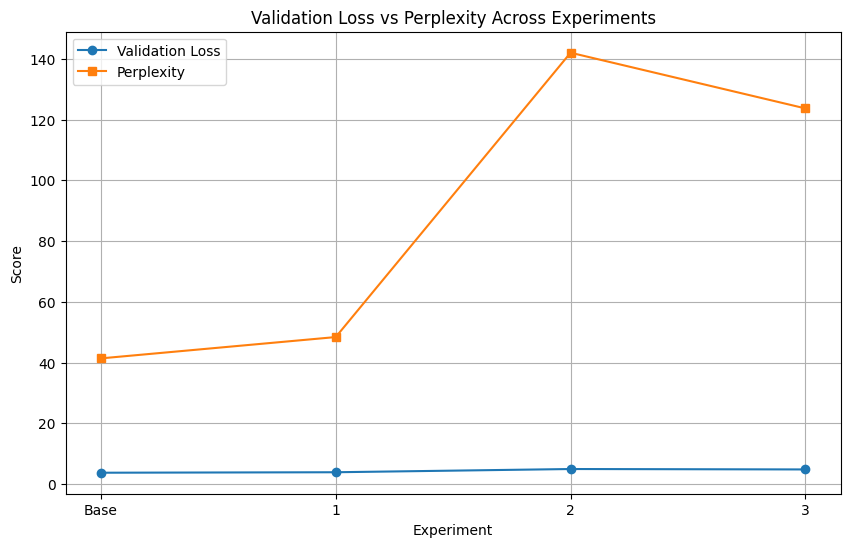

In [ ]:
import matplotlib.pyplot as plt

# Convert 'Experiment' column to string type for consistent plotting
df["Experiment"] = df["Experiment"].astype(str)

plt.figure(figsize=(10,6))
plt.plot(df["Experiment"], df["Validation Loss"], marker='o', label="Validation Loss")
plt.plot(df["Experiment"], df["Perplexity"], marker='s', label="Perplexity")
plt.title("Validation Loss vs Perplexity Across Experiments")
plt.xlabel("Experiment")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# BLEU and ROUGE-L comparison

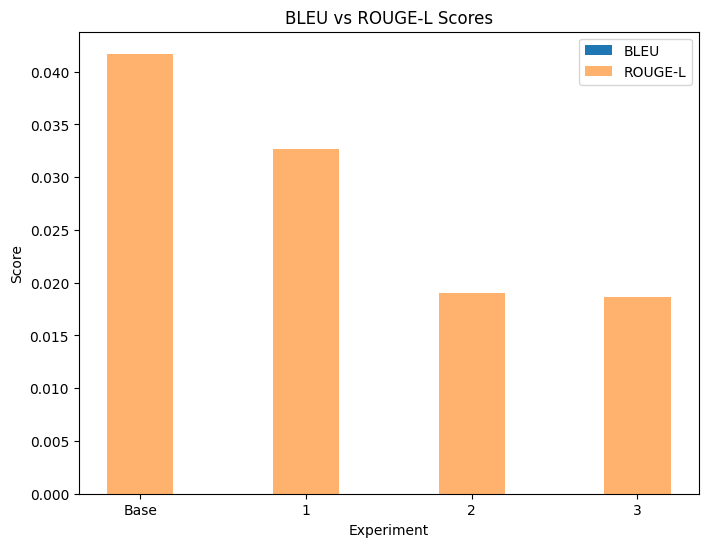

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(df["Experiment"], df["BLEU"], width=0.4, label="BLEU")
plt.bar(df["Experiment"], df["ROUGE-L"], width=0.4, label="ROUGE-L", alpha=0.6)
plt.title("BLEU vs ROUGE-L Scores")
plt.xlabel("Experiment")
plt.ylabel("Score")
plt.legend()
plt.show()

# Learning Rate vs Validation Loss

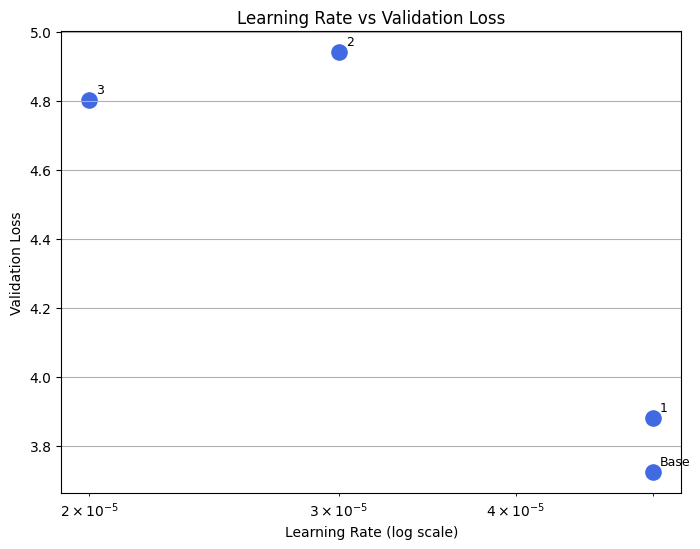

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df["Learning Rate"], df["Validation Loss"], s=120, c="royalblue")
for i, txt in enumerate(df["Experiment"]):
    plt.annotate(txt, (df["Learning Rate"][i], df["Validation Loss"][i]), fontsize=9, xytext=(5,5), textcoords='offset points')
plt.xscale('log')
plt.title("Learning Rate vs Validation Loss")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Validation Loss")
plt.grid(True)
plt.show()

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# Load best model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("best_flan_t5_healthcare_model")
model = TFAutoModelForSeq2SeqLM.from_pretrained("best_flan_t5_healthcare_model")

print("Best model loaded successfully and ready for use!")

/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at best_flan_t5_healthcare_model were not used when initializing TFT5ForConditionalGeneration: ['block_._7/layer_._1/EncDecAttention/k/kernel:0', 'block_._2/layer_._1/DenseReluDense/wo/kernel:0', 'block_._0/layer_._0/SelfAttention/o/kernel:0', 'block_._3/layer_._0/SelfAttention/k/kernel:0', 'block_._7/layer_._2/DenseReluDense/wi_0/kernel:0', 'block_._5/layer_._1/EncDecAttention/v/kernel:0', 'block_._3/layer_._1/layer_norm/weight:0', 'block_._0/layer_._2/DenseReluDense/wo/kernel:0', 'block_._1/layer_._2/DenseReluDense/wi_0/kernel:0', 'block_._6/layer_._1/Dens

Best model loaded successfully and ready for use!


In [ ]:
# Simple Chatbot
!pip install -q sentence-transformers pandas scikit-learn

import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Load your dataset
df = pd.read_csv("dataset.csv").dropna()
print(f"Loaded {len(df)} Q&A pairs")

# Encode questions once
model = SentenceTransformer("all-MiniLM-L6-v2")
question_embeddings = model.encode(df["Context"].tolist(), convert_to_tensor=True)

def get_response(user_query, top_k=1):
    """Find the dataset question most similar to user query."""
    query_emb = model.encode(user_query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_emb, question_embeddings)[0]
    best_idx = int(cos_scores.argmax())
    # Use 'Context' for best question and 'Response' for best answer
    best_question = df.iloc[best_idx]["Context"]
    best_answer = df.iloc[best_idx]["Response"]
    score = float(cos_scores[best_idx])
    return best_question, best_answer, score

# Chat loop example
print("\nChatbot ready! Type 'quit' to exit.\n")
while True:
    user_input = input("You: ")
    if user_input.lower() == "quit":
        break
    q, a, s = get_response(user_input)
    print(f"\nBot: {a}  (matched '{q}' - score {s:.2f})\n")

Loaded 3507 Q&A pairs

Chatbot ready! Type 'quit' to exit.

You: Hie, I feel worthless and my friends say the same

Bot: Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to "snap out of it" - which is also a thought that carries some self-criticism. Some people try a different approach, an

In [ ]:
!pip install transformers gradio accelerate pandas --quiet

import os
import torch
import pandas as pd
import gradio as gr
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM

# LOAD FINE-TUNED MODEL
MODEL_DIR = "best_flan_t5_healthcare_model"
if not os.path.exists(MODEL_DIR):
    raise FileNotFoundError("Model folder 'best_flan_t5_healthcare_model' not found. Upload or mount it first.")

print(f"Loading fine-tuned model from: {MODEL_DIR}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR)

# LOAD DATASET FOR QUICK RESPONSES
DATASET_PATH = "dataset.csv"
if os.path.exists(DATASET_PATH):
    df_faq = pd.read_csv(DATASET_PATH)
    df_faq.columns = df_faq.columns.str.strip()  # Clean column names
    print(f"Loaded dataset with {len(df_faq)} entries.")
else:
    print("Dataset not found. Creating empty DataFrame.")
    df_faq = pd.DataFrame(columns=["Context", "Response"])

# GENERATION SETTINGS
GEN_ARGS = dict(
    max_new_tokens=120,
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=3,
    temperature=0.7,
    early_stopping=True,
)

conversation_history = []

# RESPONSE GENERATION FUNCTION
def generate_response(user_input):
    if not user_input.strip():
        return "Please type something so I can help you."

    # Check dataset first
    if not df_faq.empty:
        # Case-insensitive search in 'Context' column
        matches = df_faq[df_faq["Context"].str.contains(user_input, case=False, na=False)]
        if not matches.empty:
            response = matches.iloc[0]["Response"]
            conversation_history.append({"User": user_input, "Bot": response})
            return response

    # If not found, use fine-tuned FLAN-T5 model ---
    inputs = tokenizer(user_input, return_tensors="tf", truncation=True, padding=True, max_length=256)
    outputs = model.generate(**inputs, **GEN_ARGS)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    conversation_history.append({"User": user_input, "Bot": response})
    return response

# BUILD GRADIO UI
with gr.Blocks(css="""
    body {background-color: #eef3f7;}
    .chatbot {border-radius: 12px; padding: 15px; background-color: #ffffff;
              box-shadow: 0 4px 12px rgba(0,0,0,0.1);}
    .action-btn {background-color: #6c63ff; color: white; padding: 10px 16px;
                 border-radius: 8px; font-weight: 600;}
    .action-btn:hover {background-color: #5a54e8;}
""") as app:

    # Header Section
    gr.Markdown(
        """
        <div style="text-align:center;">
            <h1 style="color:#2c3e50;">🧠 Mental Health Chatbot</h1>
            <p style="color:#34495e;">
            A supportive chatbot powered by your fine-tuned <b>FLAN-T5</b> model.<br>
            It uses a curated dataset for instant answers and connects you with help if needed.
            </p>
        </div>
        """,
        elem_id="header"
    )

    # Chat Section
    chatbox = gr.Chatbot(label="Chat with me", elem_classes="chatbot")

    # Input Row
    with gr.Row():
        user_input = gr.Textbox(label="Type your message", placeholder="e.g., How can I manage anxiety?")
        send_btn = gr.Button("Send", elem_classes="action-btn")
        clear_btn = gr.Button("Clear Chat", elem_classes="action-btn")

    # Action Buttons
    with gr.Row():
        speak_btn = gr.Button("📞 Speak to a Professional", elem_classes="action-btn")
        call_btn = gr.Button("📱 Call Someone", elem_classes="action-btn")

    # Chat Function
    def chat_fn(message, history):
        response = generate_response(message)
        history.append((message, response))
        return "", history

    # Button Behaviors
    user_input.submit(chat_fn, [user_input, chatbox], [user_input, chatbox])
    send_btn.click(chat_fn, [user_input, chatbox], [user_input, chatbox])
    clear_btn.click(lambda: [], None, chatbox)

    speak_btn.click(lambda: ("Connecting you to a professional...", []), None, chatbox)
    call_btn.click(lambda: ("If you need urgent help, please call your local helpline: 123-456-7890", []), None, chatbox)

app.launch(share=True)

Loading fine-tuned model from: best_flan_t5_healthcare_model


/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at best_flan_t5_healthcare_model were not used when initializing TFT5ForConditionalGeneration: ['block_._7/layer_._1/EncDecAttention/k/kernel:0', 'block_._2/layer_._1/DenseReluDense/wo/kernel:0', 'block_._0/layer_._0/SelfAttention/o/kernel:0', 'block_._3/layer_._0/SelfAttention/k/kernel:0', 'block_._7/layer_._2/DenseReluDense/wi_0/kernel:0', 'block_._5/layer_._1/EncDecAttention/v/kernel:0', 'block_._3/layer_._1/layer_norm/weight:0', 'block_._0/layer_._2/DenseReluDense/wo/kernel:0', 'block_._1/layer_._2/DenseReluDense/wi_0/kernel:0', 'block_._6/layer_._1/Dens

Loaded dataset with 3507 entries.


/tmp/ipython-input-2049439382.py:87: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbox = gr.Chatbot(label="Chat with me", elem_classes="chatbot")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0b9fac5e77714b0d0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Zipping content files for git hub upload

In [ ]:
!zip -r content_files.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.10.14/ (stored 0%)
  adding: content/.config/logs/2025.10.14/13.41.03.585119.log (deflated 86%)
  adding: content/.config/logs/2025.10.14/13.40.54.132300.log (deflated 58%)
  adding: content/.config/logs/2025.10.14/13.41.1

In [ ]:
from google.colab import files
files.download("content_files.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>